In [1]:
import os
import copy
import matplotlib.pyplot as plt
import numpy as np
import toml
import glob
from tqdm.auto import tqdm
from markovids import vid
import pandas as pd
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from qd_analysis.fig import setup_plotting_env

## User functions

In [3]:
def get_time_to_baseline(df, cutoff=None):
    _test = df.set_index("days")["value"]
    _index_cut = _test[_test>=cutoff].index
    if len(_index_cut) == 0:
        return np.nan
    else:
        return np.max(_index_cut)
    # find first timepoint that gets below cutoff...

In [4]:
save_dir = "/mnt/data/jmarkow/panels/2024-06 (QD paper)"
os.makedirs(save_dir, exist_ok=True)

In [5]:
config = toml.load("../preprocessing/config.toml")

In [6]:
fluo_df = pd.read_parquet(os.path.join(config["dirs"]["analysis"], "fluorescence_intensity_over_time.parquet"))

In [7]:
# TODO move into cleanup function
fluo_df = fluo_df.loc[~((fluo_df["start_time"].dt.floor("d") == "2024-06-10") & (fluo_df["subject"] == "qd_beads_08"))].copy()

In [8]:
plt_vars = ["q1.0_fullframe_bpass"]
agg_func = lambda x: np.quantile(x, .95)
agg_func.__name__ = "q.95"
# agg_func = np.mean

In [9]:
# plt_vars = ["std_intensity_fullframe_bpass"]
# # agg_func = lambda x: np.quantile(x, .5)
# # agg_func.__name__ = "q.95"
# agg_func = np.mean

In [10]:
plt_data = (
    fluo_df.groupby(["days", "subject", "camera", "exp_type"])[plt_vars]
    .agg(agg_func)
    # .mean()
)

In [11]:
plt_data = plt_data.melt(ignore_index=False).reset_index()

In [12]:
blank_ci = fluo_df.loc[fluo_df["exp_type"].isin(["vehicle","blank"])].groupby(["subject","filename"])[plt_vars].agg(agg_func)

In [13]:
rng = np.random.default_rng(seed=0)

In [14]:
rand_mus = [blank_ci.sample(frac=1, replace=True, random_state=rng).mean() for _ in range(1000)]
rand_mus = pd.DataFrame(rand_mus)

In [15]:
ci_high = rand_mus.mean() + 2.96 * rand_mus.std()
ci_low = rand_mus.mean() - 2.96 * rand_mus.std()

# ci_low = pd.DataFrame(rand_mus).quantile(.001)

In [16]:
def normalize_to_day0(df, val="value"):
    idx = df.index
    vals = (df[val] / df.loc[df["days"]==0][val].mean()).values
    vals *= 1e2
    return pd.Series(data=vals, index=idx, name="test").to_frame()

In [17]:
new_vals = plt_data.groupby(["subject","variable", "camera"])[["value", "days"]].apply(normalize_to_day0)
new_vals.index = new_vals.index.get_level_values(-1)

In [18]:
new_val_to_copy = plt_data.copy()
new_val_to_copy["value"] = new_vals
new_val_to_copy["variable"] = new_val_to_copy["variable"].apply(lambda x: f"{x}_norm")

In [19]:
plt_data = pd.concat([plt_data, new_val_to_copy], ignore_index=True)

In [20]:
plt_data.loc[plt_data["exp_type"].isin(["qd_cell_labels", "qd_vascular_labels"]), "exp_class"] = "base_qds"
plt_data.loc[plt_data["exp_type"].isin(["vehicle", "blank"]), "exp_class"] = "ctrl"
# plt_data.loc[plt_data["exp_type"].isin(["qd_beads"]), "exp_class"] = "beads"
# plt_data.loc[plt_data["exp_type"].isin(["qd_beads_v2"]), "exp_class"] = "beads_v2"

In [21]:
exclude_subjects = ["qd_beads_01","qd_beads_02","qd_beads_03"]

## Fig 1 comparison, qds vs blank/vehicle

In [22]:
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind
from qd_analysis.fig import setup_plotting_env

In [23]:
setup_plotting_env()

In [24]:
mu = plt_data.query("days==0 and variable==@plt_vars[0]").groupby(["exp_class","subject"])["value"].mean()

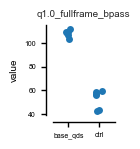

In [25]:
# fig, ax = plt.subplots(1, figsize=(2.,2.))
g = sns.catplot(
    plt_data.query("days==0 and variable==@plt_vars[0]")
    .groupby(["exp_class", "subject", "variable"])["value"]
    .mean()
    .reset_index(),
    x="exp_class",
    y="value",
    kind="strip",
    col="variable",
    sharey=False,
    height=1.5,
    aspect=.8,
)
sns.despine(offset=5, trim=False)
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.set(xlabel="")
g.fig.tight_layout()
g.fig.savefig(os.path.join(save_dir, f"qds_v_vehicle_permouse_{agg_func.__name__}.pdf"), bbox_inches="tight")

In [26]:
snr = (mu.loc["base_qds"] / mu.loc["ctrl"].mean())

In [27]:
stat_func = mannwhitneyu
val, pval = stat_func(mu.loc["base_qds"], mu.loc["ctrl"])

stat_dct = {
    "test": stat_func.__name__,
    "n": {},
    "statistic": val,
    "pval": pval,
}

In [28]:
for k, v in mu.groupby("exp_class").size().items():
    stat_dct["n"][k] = v

In [29]:
stat_dct["snr"] = {}
stat_dct["snr"]["mean"] = snr.mean()
stat_dct["snr"]["std"] = snr.std()

In [30]:
with open(os.path.join(save_dir, f"stats_figure1_{agg_func.__name__}.toml"), "w") as f:
    toml.dump(stat_dct, f)

In [31]:
stat_dct

{'test': 'mannwhitneyu',
 'n': {'base_qds': 6, 'ctrl': 6},
 'statistic': 36.0,
 'pval': 0.0021645021645021645,
 'snr': {'mean': 2.0413348024555327, 'std': 0.05331938581647871}}

## Timecourse

In [32]:
setup_plotting_env()

In [33]:
ci_color = "w" if plt.rcParams["axes.facecolor"] == "black" else "k"
# sns.set_context("paper", font_scale=.8)

In [34]:
exclude_subjects = ["qd_beads_01","qd_beads_02","qd_beads_03"]

In [35]:
hue_order=[
        "qd_vascular_labels",
        "qd_cell_labels",
        "qd_beads",
    ]

In [36]:
base_colors = sns.color_palette("deep")
palette = {"qd_vascular_labels": base_colors[0],
           "qd_cell_labels": base_colors[1],
           "qd_beads": base_colors[2],
           "qd_beads_v2": base_colors[3],
           "qd_vascular_labels_high_light": base_colors[3]}

In [37]:
plt_groups = list(palette.keys())

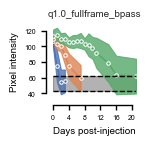

In [38]:
g = sns.relplot(
    data=plt_data.query("~subject.isin(@exclude_subjects)"),
    row="variable",
    row_order=plt_vars,
    x="days",
    y="value",
    kind="line",
    estimator="mean",
    errorbar=("sd", 1),
    facet_kws={"sharey": False},
    err_kws={"alpha": 0.8},
    palette=palette,
    hue="exp_type",
    hue_order=hue_order,
    marker="o",
    ms=2.5,
    aspect=1.,
    height=1.4,
    legend=False,
)
# g.set(xlim=(0,12))
g.set_titles(col_template="{col_name}", row_template="{row_name}")
if "qd_beads" not in hue_order[-1]:
    g.set(xlim=(0, 7), xlabel="Days post-injection")
else:
    g.set(xlim=(0, 21), xlabel="Days post-injection")
for _ax, _name in zip(g.axes.ravel(), plt_vars):
    _ax.axhline(ci_high[_name], color=ci_color, ls="--")
    _ax.axhline(ci_low[_name], color=ci_color, ls="--")
    xlim = _ax.get_xlim()
    _ax.fill_between(
        xlim, ci_low[_name], ci_high[_name], alpha=0.3, zorder=-300, color=ci_color
    )
    _ax.set_xlim(xlim)
    if "qd_beads" not in hue_order[-1]:
        _ax.set_xticks(np.arange(0, xlim[1] + 1, 1))
    else:        
        _ax.set_xticks(np.arange(0, xlim[1] + 1, 4))
g.axes[0][0].set_ylabel("Pixel intensity")
# g.axes[1][0].set_ylabel("Percent day 0")

sns.despine(offset=5, trim=True)
g.fig.savefig(os.path.join(save_dir, f"qd_fluorescence_decay_{hue_order}_{agg_func.__name__}.pdf"), bbox_inches="tight")

In [39]:
use_cutoff = ci_high[plt_vars[0]]

In [40]:
decay_times = plt_data.query("variable == @plt_vars[0] and ~subject.isin(@exclude_subjects)").groupby(["exp_type", "subject", "camera"])[
    ["subject", "camera", "days", "value"]
].apply(lambda x: get_time_to_baseline(x, use_cutoff)).dropna().rename("decay").dropna().reset_index()

In [41]:
# 1. brightness on day 0 
# 2. time to 75-50

In [42]:
decay_rate = plt_data.query("~subject.isin(@exclude_subjects) and variable == 'q1.0_fullframe_bpass_norm'").groupby(
    ["exp_type", "subject", "camera"]
).apply(lambda x: (x["value"].diff() / x["days"].diff()).mean()).rename("decay").dropna().reset_index()

/tmp/ipykernel_3859/3983213671.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: (x["value"].diff() / x["days"].diff()).mean()).rename("decay").dropna().reset_index()


In [43]:
brightness = plt_data.query("~subject.isin(@exclude_subjects) and variable == 'q1.0_fullframe_bpass' and days <= 0.0").groupby(
    ["exp_type", "subject", "camera"])["value"].mean().rename("brightness").reset_index()

In [44]:
# overall brightness

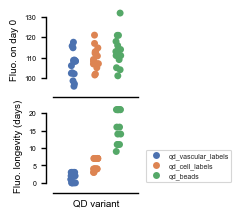

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(1.1, 2.3), sharex=True, sharey=False)
sns.stripplot(
    data=brightness,
    hue="exp_type",
    hue_order=hue_order,
    palette=palette,
    dodge=True,
    y="brightness",
    ax=ax[0],
)
sns.stripplot(
    data=decay_times,
    hue="exp_type",
    hue_order=hue_order,
    palette=palette,
    dodge=True,
    y="decay",
    ax=ax[1],
)
for _ax in ax:
    _ax.set_xticks([])
ax[0].legend().remove()
ax[0].set_ylabel("Fluo. on day 0")
ax[1].legend().remove()
ax[1].legend(bbox_to_anchor=(1.05, 0.5))
ax[1].set_xlabel("QD variant")
ax[1].set_ylabel("Fluo. longevity (days)")
sns.despine(offset=5, trim=True)
fig.savefig(os.path.join(save_dir, f"qd_fluorescence_decay_rate_brightness_{hue_order}_{agg_func.__name__}.pdf"), bbox_inches="tight")

# Looking at conjugation w/ v2

In [46]:
setup_plotting_env()

In [47]:
ci_color = "w" if plt.rcParams["axes.facecolor"] == "black" else "k"
# sns.set_context("paper", font_scale=.8)

In [48]:
fluo_df["exp_type"].unique()

array(['qd_cell_labels', 'blank', 'qd_alg', 'vehicle',
       'qd_vascular_labels', 'qd_alg_caco3', 'qd_saqd', 'qd_beads',
       'qd_beads_v2', 'null_v2', 'vehicle_v2', 'qd_cell_labels_v2',
       'qd_conj_fibro_click_v2', 'qd_conj_coll_click_v2',
       'qd_conj_fibro_bio_v2', 'qd_conj_coll_bio_v2'], dtype=object)

In [49]:
blank_ci = fluo_df.query("exp_type == 'vehicle_v2'").groupby(["subject","filename"])[plt_vars].agg(agg_func)

In [50]:
rng = np.random.default_rng(seed=0)

In [51]:
rand_mus = [blank_ci.sample(frac=1, replace=True, random_state=rng).mean() for _ in range(1000)]
rand_mus = pd.DataFrame(rand_mus)

In [52]:
ci_high = rand_mus.mean() + 2.96 * rand_mus.std()
ci_low = rand_mus.mean() - 2.96 * rand_mus.std()

# ci_low = pd.DataFrame(rand_mus).quantile(.001)

In [53]:
hue_order=[
        # "qd_cell_labels_v2", 
        "qd_beads_v2",
        "qd_conj_coll_click_v2",
        "qd_conj_fibro_click_v2",
        # "qd_conj_coll_bio_v2",
        # "qd_conj_fibro_bio_v2",
        # "vehicle_v2",
    ]

In [54]:
palette = sns.color_palette("bright")[2:]
# palette = {"qd_vascular_labels": base_colors[0],
#            "qd_cell_labels": base_colors[1],
#            "qd_beads": base_colors[2],
#            "qd_beads_v2": base_colors[3],
#            "qd_vascular_labels_high_light": base_colors[3]}

In [55]:
palette

[(0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [56]:
# sns.set_context("paper")

In [57]:
# plt.style.use("dark_background")

In [58]:
ci_color = "w" if plt.rcParams["axes.facecolor"] == "black" else "k"
# sns.set_context("paper", font_scale=.8)

/tmp/ipykernel_3859/3851929395.py:1: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.relplot(


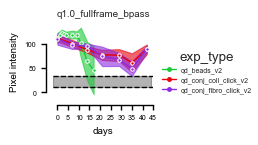

In [59]:
g = sns.relplot(
    data=plt_data.query("~subject.isin(@exclude_subjects)"),
    row="variable",
    row_order=plt_vars,
    x="days",
    y="value",
    kind="line",
    estimator="mean",
    errorbar=("sd", 1),
    facet_kws={"sharey": False},
    err_kws={"alpha": 0.6},
    palette=palette,
    hue="exp_type",
    hue_order=hue_order,
    marker="o",
    ms=2.5,
    aspect=1.25,
    height=1.4,
    # legend=False,
)
# g.set(xlim=(0,12))
g.set_titles(col_template="{col_name}", row_template="{row_name}")
# g.set(xlim=(0,30))
g.axes[0][0].set_ylabel("Pixel intensity")

for _ax, _name in zip(g.axes.ravel(), plt_vars):
    _ax.axhline(ci_high[_name], color=ci_color, ls="--")
    _ax.axhline(ci_low[_name], color=ci_color, ls="--")
    xlim = _ax.get_xlim()
    _ax.fill_between(
        xlim, ci_low[_name], ci_high[_name], alpha=0.3, zorder=-300, color=ci_color
    )
    _ax.set_xlim(xlim)
    _ax.set_xticks(np.arange(0, xlim[1] + 1, 5))

sns.despine(offset=5, trim=True)
g.fig.savefig(os.path.join(save_dir, f"qd_fluorescence_decay_{hue_order}_{agg_func.__name__}_rigv2.pdf"), bbox_inches="tight")

In [60]:
use_cutoff_v2 = ci_high[plt_vars[0]]

In [61]:
decay_times_v2 = plt_data.query("variable == @plt_vars[0] and ~subject.isin(@exclude_subjects)").groupby(["exp_type", "subject", "camera"])[
    ["subject", "camera", "days", "value"]
].apply(lambda x: get_time_to_baseline(x, use_cutoff_v2)).dropna().rename("decay").dropna().reset_index()

In [62]:
decay_rate_v2 = plt_data.query("~subject.isin(@exclude_subjects) and variable == 'q1.0_fullframe_bpass_norm'").groupby(
    ["exp_type", "subject", "camera"]
).apply(lambda x: (x["value"].diff() / x["days"].diff()).mean()).rename("decay").dropna().reset_index()

/tmp/ipykernel_3859/1378884127.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: (x["value"].diff() / x["days"].diff()).mean()).rename("decay").dropna().reset_index()


In [63]:
# brightness_v2 = plt_data.query("~subject.isin(@exclude_subjects) and variable == 'q1.0_fullframe_bpass' and days <= 0.0").groupby(
#     ["exp_type", "subject", "camera"])["value"].mean().rename("brightness").reset_index()

In [64]:
# overall brightness

/tmp/ipykernel_3859/1625300204.py:2: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.stripplot(
/tmp/ipykernel_3859/1625300204.py:11: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.stripplot(


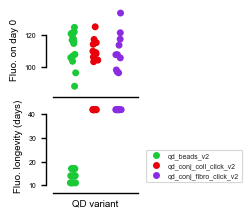

In [65]:
fig, ax = plt.subplots(2, 1, figsize=(1.1, 2.3), sharex=True, sharey=False)
sns.stripplot(
    data=brightness,
    hue="exp_type",
    hue_order=hue_order,
    palette=palette,
    dodge=True,
    y="brightness",
    ax=ax[0],
)
sns.stripplot(
    data=decay_times_v2,
    hue="exp_type",
    hue_order=hue_order,
    palette=palette,
    dodge=True,
    y="decay",
    ax=ax[1],
)
for _ax in ax:
    _ax.set_xticks([])
ax[0].legend().remove()
ax[0].set_ylabel("Fluo. on day 0")
ax[1].legend().remove()
ax[1].legend(bbox_to_anchor=(1.05, 0.5))
ax[1].set_xlabel("QD variant")
ax[1].set_ylabel("Fluo. longevity (days)")
sns.despine(offset=5, trim=True)
fig.savefig(os.path.join(save_dir, f"qd_fluorescence_decay_rate_brightness_{hue_order}_{agg_func.__name__}_rigv2.pdf"), bbox_inches="tight")

# Slightly different brightness calculations for beads_v2 (account for mean better)

In [66]:
plt_vars = ["std_intensity_fullframe_bpass"]
# agg_func = lambda x: np.quantile(x, .5)
# agg_func.__name__ = "q.95"
agg_func_snr = np.mean

In [67]:
plt_data = (
    fluo_df.groupby(["days", "subject", "camera", "exp_type"])[plt_vars]
    .agg(agg_func_snr)
    # .mean()
)

/tmp/ipykernel_3859/692032113.py:3: FutureWarning: The provided callable <function mean at 0x7fd84aafadd0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg(agg_func_snr)


In [68]:
plt_data = plt_data.melt(ignore_index=False).reset_index()

In [69]:
plt_data.loc[plt_data["exp_type"].isin(["qd_cell_labels", "qd_vascular_labels"]), "exp_class"] = "base_qds"
plt_data.loc[plt_data["exp_type"].isin(["vehicle", "blank"]), "exp_class"] = "ctrl"

In [70]:
brightness_snr = plt_data.query("~subject.isin(@exclude_subjects) and variable == @plt_vars[0] and days <= 0.0").groupby(
    ["exp_type", "subject", "camera"])["value"].mean().rename("brightness").reset_index()

In [71]:
reader = vid.io.AutoReader(fluo_df["filename"].iat[0])

In [72]:
npixels = np.prod(reader.frame_size)

In [73]:
reader.close()

In [74]:
hue_order = ["qd_vascular_labels", "qd_cell_labels", "qd_beads", "qd_beads_v2"]

In [75]:
baseline = brightness_snr.query("exp_type in ['blank','vehicle']")

In [76]:
baseline_v2 = brightness_snr.query("exp_type in ['vehicle_v2']")

In [77]:
snr_v2 = brightness_snr.query("exp_type.str.contains('v2')")["brightness"] / baseline_v2["brightness"].mean()

In [78]:
snr_v2

15     1.466314
16     1.035481
17     1.376678
18     1.200158
19     0.838768
         ...   
195    1.251928
196    0.797211
197    1.131404
198    1.272751
199    0.754566
Name: brightness, Length: 90, dtype: float64

In [79]:
brightness_snr["snr"] = brightness_snr["brightness"] / baseline["brightness"].mean()
brightness_snr.loc[snr_v2.index, "snr"] = snr_v2 

In [80]:
setup_plotting_env()

In [81]:
# sns.set_context("paper")

/tmp/ipykernel_3859/1401599070.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["var. 1","var. 2","var. 3","var. 3 (rig v2)"])


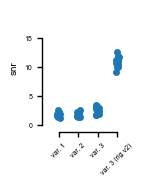

In [82]:
fig, ax = plt.subplots(1, figsize=(1,1.5))
sns.stripplot(brightness_snr,
              x="exp_type",
              y="snr",
              order=hue_order)
ax.set_yticks(np.arange(0, 20, 5))
ax.set_xticklabels(["var. 1","var. 2","var. 3","var. 3 (rig v2)"])
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("")
ax.set_ylim(0, 20)
sns.despine(offset=5, trim=True)
fig.savefig(os.path.join(save_dir, "beads_v2_snr_comparison.pdf"), bbox_inches="tight", dpi=600)

In [83]:
stat_func = mannwhitneyu
groups = sorted(["qd_cell_labels", "qd_vascular_labels", "qd_beads","qd_beads_v2", "qd_conj_coll_click_v2","qd_conj_fibro_click_v2"])
stat_dct = {}
for i, _group1 in enumerate(groups):
    for _group2  in groups[i+1:]:
        if _group1 == _group2:
            continue
        dat = decay_times.set_index("exp_type")["decay"]
        dat1 = dat.loc[_group1]
        dat2 = dat.loc[_group2]
        n1 = len(dat1)
        n2 = len(dat2)
        val, pval = stat_func(dat1, dat2)
        subkey = f"{_group1}-{_group2}"
        stat_dct[subkey] = {}
        stat_dct[subkey]["decay_time"] = {}
        stat_dct[subkey]["decay_time"]["statistic"] = val
        stat_dct[subkey]["decay_time"]["pval"] = pval
        stat_dct[subkey]["decay_time"]["test"] = stat_func.__name__
        stat_dct[subkey]["decay_time"]["f"] = val  / (n1*n2)


        dat = decay_times_v2.set_index("exp_type")["decay"]
        dat1 = dat.loc[_group1]
        dat2 = dat.loc[_group2]
        n1 = len(dat1)
        n2 = len(dat2)
        val, pval = stat_func(dat1, dat2)
        subkey = f"{_group1}-{_group2}"
        stat_dct[subkey]["decay_time_v2"] = {}
        stat_dct[subkey]["decay_time_v2"]["statistic"] = val
        stat_dct[subkey]["decay_time_v2"]["pval"] = pval
        stat_dct[subkey]["decay_time_v2"]["test"] = stat_func.__name__
        stat_dct[subkey]["decay_time_v2"]["f"] = val  / (n1*n2)

        dat = brightness.set_index("exp_type")["brightness"]
        dat1 = dat.loc[_group1]
        dat2 = dat.loc[_group2]
        n1 = len(dat1)
        n2 = len(dat2)
        val, pval = stat_func(dat1, dat2)
        subkey = f"{_group1}-{_group2}"
        stat_dct[subkey]["brightness"] = {}
        stat_dct[subkey]["brightness"]["statistic"] = val
        stat_dct[subkey]["brightness"]["pval"] = pval
        stat_dct[subkey]["brightness"]["test"] = stat_func.__name__
        stat_dct[subkey]["brightness"]["f"] = val  / (n1*n2)

        dat = brightness_snr.set_index("exp_type")["snr"]
        dat1 = dat.loc[_group1]
        dat2 = dat.loc[_group2]
        n1 = len(dat1)
        n2 = len(dat2)
        val, pval = stat_func(dat1, dat2)
        subkey = f"{_group1}-{_group2}"
        stat_dct[subkey]["brightness_snr"] = {}
        stat_dct[subkey]["brightness_snr"]["statistic"] = val
        stat_dct[subkey]["brightness_snr"]["pval"] = pval
        stat_dct[subkey]["brightness_snr"]["test"] = stat_func.__name__
        stat_dct[subkey]["brightness_snr"]["f"] = val  / (n1*n2)
        
# stat_dct = {
#     "test": stat_func.__name__,
#     "n": {},
#     "statistic": val,
#     "pval": pval,
# }

In [84]:
stat_dct["n"] = {}
for k, v in decay_rate.groupby("exp_type").size().items():
    stat_dct["n"][k] = v

In [85]:
stat_dct

{'qd_beads-qd_beads_v2': {'decay_time': {'statistic': 165.5,
   'pval': 0.026159040214902035,
   'test': 'mannwhitneyu',
   'f': 0.7355555555555555},
  'decay_time_v2': {'statistic': 220.0,
   'pval': 2.3986254031068648e-06,
   'test': 'mannwhitneyu',
   'f': 0.9777777777777777},
  'brightness': {'statistic': 106.0,
   'pval': 0.8033339632526271,
   'test': 'mannwhitneyu',
   'f': 0.4711111111111111},
  'brightness_snr': {'statistic': 0.0,
   'pval': 3.3918213908250945e-06,
   'test': 'mannwhitneyu',
   'f': 0.0}},
 'qd_beads-qd_cell_labels': {'decay_time': {'statistic': 225.0,
   'pval': 2.2760631419476453e-06,
   'test': 'mannwhitneyu',
   'f': 1.0},
  'decay_time_v2': {'statistic': 225.0,
   'pval': 1.9732739133712241e-07,
   'test': 'mannwhitneyu',
   'f': 1.0},
  'brightness': {'statistic': 144.5,
   'pval': 0.191115455995173,
   'test': 'mannwhitneyu',
   'f': 0.6422222222222222},
  'brightness_snr': {'statistic': 195.0,
   'pval': 0.0006709034051003711,
   'test': 'mannwhitneyu'

In [86]:
decay_rate_summary_dict = decay_rate.groupby("exp_type")["decay"].agg(["mean","std"]).to_dict()
decay_times_summary_dict = decay_times.groupby("exp_type")["decay"].agg(["mean","std"]).to_dict()
brightness_summary_dict = brightness.groupby("exp_type")["brightness"].agg(["mean","std"]).to_dict()
decay_rate_v2_summary_dict = decay_rate_v2.groupby("exp_type")["decay"].agg(["mean","std"]).to_dict()
decay_times_v2_summary_dict = decay_times_v2.groupby("exp_type")["decay"].agg(["mean","std"]).to_dict()
# brightness_v2_summary_dict = brightness_v2.groupby("exp_type")["brightness"].agg(["mean","std"]).to_dict()
snr_summary_dict = brightness_snr.groupby("exp_type")["snr"].agg(["mean","std"]).to_dict()

In [87]:
decay_times

,exp_type,subject,camera,decay
0,blank,qd_blank,Basler-267601741000-24383488,0.0
1,blank,qd_blank,Basler-26760175421F-24461855,0.0
2,blank,qd_blank_01,Basler-26760175421F-24461855,0.0
3,blank,qd_blank_02,Basler-267601746223-24404515,0.0
4,blank,qd_blank_02,Basler-26760175421F-24461855,0.0
...,...,...,...,...
158,qd_vascular_labels,qd_vasc_03,Basler-2676017611A4-24514980,0.0
159,vehicle,qd_vehicle_01,Basler-267601746223-24404515,0.0
160,vehicle,qd_vehicle_01,Basler-26760175421F-24461855,0.0
161,vehicle,qd_vehicle_03,Basler-267601746223-24404515,0.0


In [88]:
stat_dct["decay_rate_summary"] = decay_rate_summary_dict
stat_dct["decay_times_summary"] = decay_times_summary_dict
stat_dct["brightness_summary"] = brightness_summary_dict
stat_dct["decay_rate_v2_summary"] = decay_rate_v2_summary_dict
stat_dct["decay_times_v2_summary"] = decay_times_v2_summary_dict
# stat_dct["brightness_v2_summary"] = brightness_summary_dict
stat_dct["snr_summary"] = snr_summary_dict

In [89]:
with open(os.path.join(save_dir, f"stats_figure1_brightness_and_decay_{agg_func.__name__}.toml"), "w") as f:
    toml.dump(stat_dct, f)

In [90]:
7613 / np.sum(range(290))

0.18167283140436702

In [91]:
stat_dct["decay_times_v2_summary"]

{'mean': {'blank': 0.0,
  'null_v2': 4.384615384615385,
  'qd_alg': 0.8,
  'qd_alg_caco3': 1.4,
  'qd_beads': 20.666666666666668,
  'qd_beads_v2': 14.0,
  'qd_cell_labels': 6.8,
  'qd_cell_labels_v2': 15.4,
  'qd_conj_coll_bio_v2': 10.5,
  'qd_conj_coll_click_v2': 42.0,
  'qd_conj_fibro_bio_v2': 14.0,
  'qd_conj_fibro_click_v2': 42.0,
  'qd_saqd': 0.8666666666666667,
  'qd_vascular_labels': 3.0,
  'vehicle': 0.0,
  'vehicle_v2': 0.0},
 'std': {'blank': 0.0,
  'null_v2': 1.5566235649883127,
  'qd_alg': 0.4216370213557839,
  'qd_alg_caco3': 0.8432740427115677,
  'qd_beads': 1.290994448735805,
  'qd_beads_v2': 2.53546276418555,
  'qd_cell_labels': 0.7745966692414834,
  'qd_cell_labels_v2': 2.9514591494904874,
  'qd_conj_coll_bio_v2': 4.949747468305833,
  'qd_conj_coll_click_v2': 0.0,
  'qd_conj_fibro_bio_v2': 0.0,
  'qd_conj_fibro_click_v2': 0.0,
  'qd_saqd': 0.35186577527449836,
  'qd_vascular_labels': 0.0,
  'vehicle': 0.0,
  'vehicle_v2': 0.0}}

In [92]:
len(plt_data.query("exp_type == 'vehicle_v2'"))

10